In [2]:
%matplotlib inline
import pymysql as mdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# connect to mysql db
con = mdb.connect('localhost', 'root', '', 'RNAseq1') #host, user, password, #database

In [4]:
# connect to IDKey
with con:
    cur = con.cursor()
    cur.execute("SELECT * FROM IDKey;") # AMP-AD_ROSMAP_Rush-Broad_IDKey.csv
    rows = cur.fetchall()

# load IDKey
colnames = tuple([desc[0] for desc in cur.description])
idkey = pd.DataFrame(list(rows),columns=colnames)
idkey = idkey.set_index(idkey.projid)
idkey = idkey.drop(['projid', 'ind'], axis=1)

# get samples with microrna data
mirnaids = idkey.loc[idkey['mirna_data']==1,'mirna_id']
#type(mirnaids)
#pd.Series.to_csv(mirnaids,"tmp.csv")

In [5]:
#idkey.loc[idkey.index == 21274866]
#mirna.loc[:,'DLPFC_610_M4_7A']

there are 3 ids for projid 82317494
there are 10 ids for projid 21274866

In [6]:
mirna = pd.DataFrame.from_csv("mirna.csv") # dlpfc_mirna_nanostring_final.gct in csv format
mirna.shape

(309, 703)

In [7]:
# map mirna ids to projids
tmp = dict(zip(idkey.mirna_id, idkey.index))
mirna= pd.DataFrame.rename(mirna,columns=tmp)

mirna.shape

(309, 703)

In [8]:
# connect to Clinical data
with con:
    cur = con.cursor()
    cur.execute("SELECT * FROM Clinical;") # AMP-AD_ROSMAP_Rush-Broad_Clinical.csv
    rows = cur.fetchall()

# load Clinical data
colnames = tuple([desc[0] for desc in cur.description])
clin = pd.DataFrame(list(rows),columns=colnames)
clin = clin.set_index(clin.projid)
clin = clin.drop(['projid','ind'], axis=1)
#clin.head()

In [9]:
# print clinical variations in sorted order
mirnaclin = clin[clin.index.isin(list(mirna.T.index))]

# remove samples with cogdx values 0,3,5,6
mirnaclin = mirnaclin.loc[mirnaclin['cogdx'].isin([1,2,4])]
mirnaclin = pd.DataFrame.sort_index(mirnaclin)
pd.DataFrame.to_csv(mirnaclin[['pmi','apoe_genotype','cogdx']],"mirna_clin.csv")

In [10]:
# get samples with proper cogdx
mirna = mirna.T[mirna.T.index.isin(list(mirnaclin.index))]
mirna = pd.DataFrame.sort_index(mirna).T
pd.DataFrame.to_csv(mirna,"mirna_sorted.csv")
#mirna.head()

# 1. Let's plot some plots

In [11]:
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

X = pd.DataFrame.as_matrix(mirna.T)

y = pd.Series.as_matrix(mirnaclin.cogdx)
y = np.array([0 if x == 1 else x for x in y])
y = np.array([1 if x == 2 else x for x in y])
y = np.array([2 if x == 4 else x for x in y])

target_names = np.array(["control","MCI","AZ"])

In [12]:
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)
lda = LDA(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

/home/sun-gou/anaconda2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:453: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


explained variance ratio (first two components): [ 0.14038544  0.08108   ]


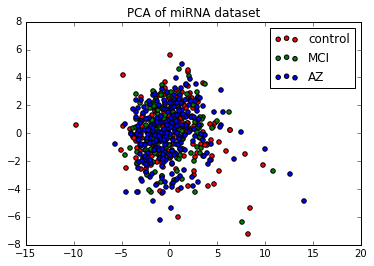

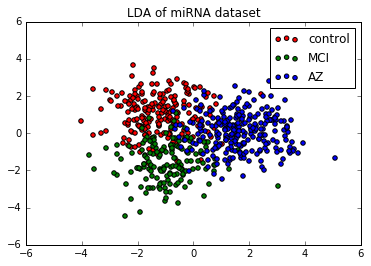

In [13]:
# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

fig = plt.figure()
for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], c=c, label=target_name)
plt.legend()
plt.title('PCA of miRNA dataset')
fig.savefig('miRNA_PCA.jpg', bbox_inches='tight')

fig = plt.figure()
for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
    plt.scatter(X_r2[y == i, 0], X_r2[y == i, 1], c=c, label=target_name)
plt.legend()
plt.title('LDA of miRNA dataset')
fig.savefig('miRNA_LDA.jpg', bbox_inches='tight')

plt.show()

# 2. Prediction without feature selection

In [25]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_curve, auc

# controls, MCI, and AZ labels
labels = mirnaclin['cogdx'].values.tolist()
bin_labels = [1 if x == 4 else 0 for x in labels]

# training and test set
(X_train, X_test, y_train, y_test) = train_test_split(mirna.T,bin_labels,test_size=0.2,stratify=labels,random_state=0)

# set up 5X crossvalidation within training set
slo = StratifiedShuffleSplit(y_train, n_iter=5, test_size=0.2, random_state=0)

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.lda import LDA

In [27]:
# Random Forest
params = [{'n_estimators': [10,50,100,200,300,400,500,1000]}]
rf = GridSearchCV(RandomForestClassifier(), params, cv =slo, scoring='roc_auc')
rf.fit(X_train, y_train)
rf = rf.best_estimator_
print("Random Forest accuracy = {}".format(rf.score(X_test,y_test)))

Random Forest accuracy = 0.653225806452


In [28]:
rf.n_estimators

500

In [29]:
rf_score = rf.predict_proba(X_test)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test,rf_score[:,1])
rf_roc_auc = auc(rf_fpr, rf_tpr)
rf_roc_auc

0.70662162162162168

In [30]:
# Elastic Net
params = [{'l1_ratio': [0,0.25,0.5,0.75,1], 'alpha': [0.01,0.1,1,10,100,1000]}]
el = GridSearchCV(ElasticNet(), params, cv = slo, scoring='roc_auc')
el.fit(X_train, y_train)
el = el.best_estimator_
print("Elastic Net accuracy = {}".format(el.score(X_test,y_test)))

/home/sun-gou/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:454: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/home/sun-gou/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


Elastic Net accuracy = 0.234129243795


In [31]:
print(el.l1_ratio)
print(el.alpha)

0.5
0.01


In [32]:
el_score = el.decision_function(X_test)
el_fpr, el_tpr, el_thresholds = roc_curve(y_test,el_score)
el_roc_auc = auc(el_fpr, el_tpr)
el_roc_auc

/home/sun-gou/anaconda2/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function decision_function is deprecated;  and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


0.79729729729729726

In [33]:
# LDA
params = [{'solver': ['svd','lsqr']}]
lda = GridSearchCV(LDA(), params, cv=slo, scoring='roc_auc')
lda.fit(X_train, y_train)
lda = lda.best_estimator_
print("LDA accuracy = {}".format(lda.score(X_test,y_test)))

LDA accuracy = 0.661290322581


In [34]:
lda.solver

'svd'

In [35]:
lda_score = lda.decision_function(X_test)
lda_fpr, lda_tpr, lda_thresholds = roc_curve(y_test,lda_score)
lda_roc_auc = auc(lda_fpr, lda_tpr)
lda_roc_auc

0.67486486486486497

In [36]:
# Logistic Regression
params = [{'solver': ['newton-cg','lbfgs','liblinear','sag']}]
lr = GridSearchCV(LogisticRegression(), params, cv=slo, scoring='roc_auc')
lr.fit(X_train, y_train)
lr = lr.best_estimator_
print("Logistic Regression accuracy = {}".format(lr.score(X_test,y_test)))

/home/sun-gou/anaconda2/lib/python2.7/site-packages/scipy/optimize/linesearch.py:414: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/sun-gou/anaconda2/lib/python2.7/site-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/sun-gou/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/sag.py:267: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Logistic Regression accuracy = 0.693548387097


In [37]:
lr.solver

'sag'

In [38]:
lr_score = lr.decision_function(X_test)
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test,lr_score)
lr_roc_auc = auc(lr_fpr, lr_tpr)
lr_roc_auc

0.77054054054054055

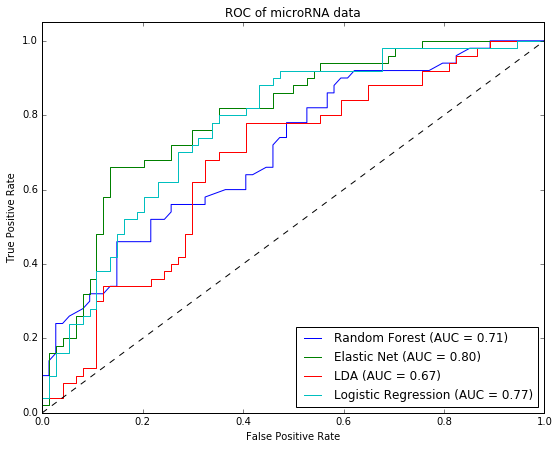

In [39]:
# Plot ROC curve
fig = plt.figure(1, figsize=(9, 7))
plt.plot(rf_fpr, rf_tpr, label='Random Forest (AUC = %0.2f)' % rf_roc_auc)
plt.plot(el_fpr, el_tpr, label='Elastic Net (AUC = %0.2f)' % el_roc_auc)
plt.plot(lda_fpr, lda_tpr, label='LDA (AUC = %0.2f)' % lda_roc_auc)
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression (AUC = %0.2f)' % lr_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of microRNA data')
plt.legend(loc="lower right")

fig.savefig('microRNA_all.ROC.jpg', bbox_inches='tight')
plt.show()

works surprisingly well even without feature selection

# 3. Prediction after feature selection

## 3.1 Run feature selection on limma

In [42]:
# output training data for limma input in R
X_tmp = pd.DataFrame.sort_index(X_train)
pd.DataFrame.to_csv(X_tmp.T,"mirna_sorted2.csv")
mirnaclin2 = mirnaclin[mirnaclin.index.isin(list(X_train.index))]
mirnaclin2 = pd.DataFrame.sort_index(mirnaclin2)
pd.DataFrame.to_csv(mirnaclin2[['pmi','apoe_genotype','cogdx']],"mirna_clin2.csv")

In [43]:
os.system("R CMD BATCH run_limma_miRNA.R")

0

In [44]:
degs = open("mirna_deg2_fdr0.05.txt", "r").read().split('\n')
del degs[-1] # remove last empty character caused by spliting
mirna_degs = mirna[mirna.index.isin(list(degs))]
pd.DataFrame.to_csv(mirna_degs,"mirna_sorted_degs.csv")
mirna_degs.shape

(29, 620)

## 3.2 Run prediction

In [45]:
X_train = X_train.loc[:,degs]
X_test = X_test.loc[:,degs]

In [46]:
# Random Forest
params = [{'n_estimators': [10,50,100,200,300,400,500,1000]}]
rf = GridSearchCV(RandomForestClassifier(), params, cv =slo, scoring='roc_auc')
rf.fit(X_train, y_train)
rf = rf.best_estimator_
print("Random Forest accuracy = {}".format(rf.score(X_test,y_test)))

Random Forest accuracy = 0.725806451613


In [47]:
rf.n_estimators

400

In [48]:
rf_score = rf.predict_proba(X_test)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test,rf_score[:,1])
rf_roc_auc = auc(rf_fpr, rf_tpr)
rf_roc_auc

0.73256756756756758

In [49]:
# Elastic Net
params = [{'l1_ratio': [0,0.25,0.5,0.75,1], 'alpha': [0.01,0.1,1,10,100,1000]}]
el = GridSearchCV(ElasticNet(), params, cv = slo, scoring='roc_auc')
el.fit(X_train, y_train)
el = el.best_estimator_
print("Elastic Net accuracy = {}".format(el.score(X_test,y_test)))

Elastic Net accuracy = 0.244934889762


In [50]:
print(el.l1_ratio)
print(el.alpha)

0.25
0.01


In [51]:
el_score = el.decision_function(X_test)
el_fpr, el_tpr, el_thresholds = roc_curve(y_test,el_score)
el_roc_auc = auc(el_fpr, el_tpr)
el_roc_auc

/home/sun-gou/anaconda2/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function decision_function is deprecated;  and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


0.79729729729729726

In [52]:
# LDA
params = [{'solver': ['svd','lsqr']}]
lda = GridSearchCV(LDA(), params, cv=slo, scoring='roc_auc')
lda.fit(X_train, y_train)
lda = lda.best_estimator_
print("LDA accuracy = {}".format(lda.score(X_test,y_test)))

LDA accuracy = 0.685483870968


In [53]:
lda.solver

'svd'

In [54]:
lda_score = lda.decision_function(X_test)
lda_fpr, lda_tpr, lda_thresholds = roc_curve(y_test,lda_score)
lda_roc_auc = auc(lda_fpr, lda_tpr)
lda_roc_auc

0.7827027027027027

In [55]:
# Logistic Regression
params = [{'solver': ['newton-cg','lbfgs','liblinear','sag']}]
lr = GridSearchCV(LogisticRegression(), params, cv=slo, scoring='roc_auc')
lr.fit(X_train, y_train)
lr = lr.best_estimator_
print("Logistic Regression accuracy = {}".format(lr.score(X_test,y_test)))

Logistic Regression accuracy = 0.717741935484


In [56]:
lr.solver

'liblinear'

In [57]:
lr_score = lr.decision_function(X_test)
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test,lr_score)
lr_roc_auc = auc(lr_fpr, lr_tpr)
lr_roc_auc

0.78162162162162163

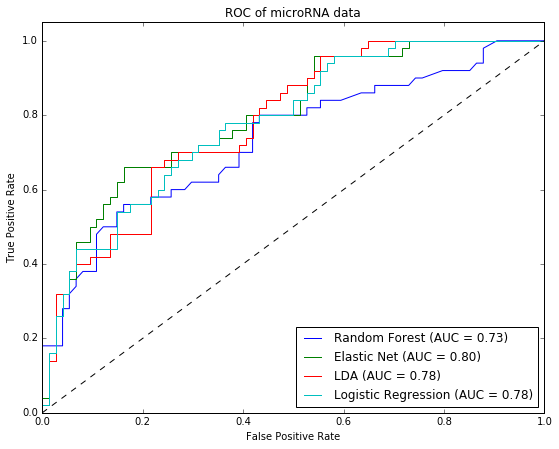

In [58]:
# Plot ROC curve
fig = plt.figure(1, figsize=(9, 7))
plt.plot(rf_fpr, rf_tpr, label='Random Forest (AUC = %0.2f)' % rf_roc_auc)
plt.plot(el_fpr, el_tpr, label='Elastic Net (AUC = %0.2f)' % el_roc_auc)
plt.plot(lda_fpr, lda_tpr, label='LDA (AUC = %0.2f)' % lda_roc_auc)
plt.plot(lr_fpr, lr_tpr, label='Logistic Regression (AUC = %0.2f)' % lr_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of microRNA data')
plt.legend(loc="lower right")

fig.savefig('microRNA_DEG.ROC.jpg', bbox_inches='tight')
plt.show()